# Lab 2:

The main purpose of Lab 0 is to familiarize yourselves with the camera. You should be able to capture an image, establish a basic understanding of camera parameters and adjust them in live image display to obatin the best image possible

### Import basic Python modules 

In [3]:
# Required imports 
import sys
import os
from PIL import Image
import numpy as np
import time
import matplotlib.pyplot as plt
import cv2
# from instrumental.drivers.cameras import uc480
import scipy.io as sio

import cv2
import scipy.stats as stats
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
import plotly.express as px
import skimage.io as skio

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Camera object instantiation

In [ ]:
# initialize camera 
# lists the cameras that are detected. 
instruments = uc480.list_instruments()
# initiliaze the camera using the detected cameras.
cam = uc480.UC480_Camera(instruments[0])
# Open Camera. DONT FORGET TO CLOSE!
cam.open()

### Check camera properties, change Camera settings and grab an image. 

In [ ]:
# Connect to the camera and set up the image memory
cam.open()
# view current camera params. 
cam.get_parameters()

Exposure Time: 66.62091228070176ms
Exposure Time Range: [0.008982456140350877 66.62091228070176]
Framerate: 14.997947649269046Hz
Pixel Clock: 24MHz
Gain: 1.0


#### Set Framerate

In [ ]:
# set frame rate
cam.set_framerate(framerate = "7Hz")
# get exposure range, you can see that the frame rate will change the maximum exposure time. 
print(cam._get_exposure_range())
# print current frame rate
print(cam.framerate)

(<Quantity(0.00898245614, 'millisecond')>, <Quantity(142.790456, 'millisecond')>)
7.000578714507065 hertz


#### Set Exposure Time 

In [ ]:
# get exposure range
cam._get_exposure_range()
"""
(0.008982456140350877 <Unit('millisecond')>,
 142.79045614035087 <Unit('millisecond')>)
"""

# set cam exposure (ms) 
cam._set_exposure('25 ms')
cam._get_exposure()


24.999797750787227 <Unit('millisecond')>

#### Setting Pixel Clock

In [ ]:
# Set pixelclock (Use the default)
cam.set_pixelclock(pixel_clock='7MHz')

# show the current pixel clock. 
cam.pixelclock

7 <Unit('megahertz')>

#### Setting Gain 

In [ ]:
# The master gain factor; 1.0 is the lowest gain, max gain is 4.0
# Use the default gain. 
cam._set_gain(30)

# get max gain 
cam.max_master_gain

# get current gain. 
cam.master_gain

1.92

In [ ]:
cam.get_parameters()

Exposure Time: 85.50282844836643ms
Exposure Time Range: [0.008982456140350877 488.26301754385963]
Framerate: 2.0472896614601814Hz
Pixel Clock: 7MHz
Gain: 1.92


In [ ]:
print(cam._width)

1280


In [ ]:
print(cam._height)

1024


In [ ]:
x0, y0 = 0, 0
# this sets the width and height of the rectangle. 
width, height = 1280, 1024
cam._set_AOI(x0, y0, width, height)
cam._get_AOI()


(0, 0, 1280, 1024)

In [ ]:
## Part 1
# Taking 300 frames dark images at 100x100 AOI to calculate covariance and noise spectrum
x0, y0 = 0, 0
# this sets the width and height of the rectangle. 
width, height = 1280, 1024
cam._set_AOI(x0, y0, width, height)
cam._get_AOI()
 
x = np.zeros((300,100,100))    
for i in range(300):
    print(i)
   
    #take an image
    img = cam.grab_image().copy()

    x[i,:,:] = img[200:300, 200:300]
# average = np.mean(avg,axis = 0)
# variance = np.var(avg, axis = 0)

In [ ]:
sio.savemat("300framesAOI_part1.mat", {"Images":x})

In [ ]:
x = sio.loadmat("/content/drive/MyDrive/Imaging_Instrumentation_Labs/Lab 2/300framesAOI_part1.mat")["Images"]

In [ ]:
# x = x[:,0:60,0:60]

In [ ]:
## Part 1
# Calculate covariance from 300 frames
'''
x: center image pixel for one frame
mean x: mean of center image pixel for 300 frames
y:  image pixels for one frame
mean y: mean of image pixels for 300 frames
'''
y = x
y_avg = np.mean(y, axis = 0)
y_minus_yavg = np.zeros((x.shape[0], x.shape[1], x.shape[2]))
x_minus_xavg = np.zeros((x.shape[0],1,1))
for i in range(x.shape[0]):
    y_minus_yavg[i,:,:] = y[i,:,:] - y_avg[:,:]
    x_minus_xavg[i] = y[i,30,30] - y_avg[30,30]
product = np.sum(np.multiply(x_minus_xavg ,y_minus_yavg),axis = 0)
covariance = product/299

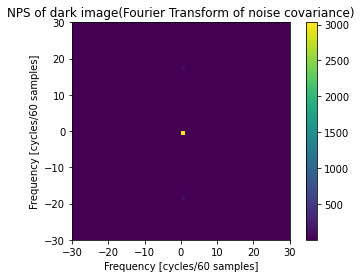

In [ ]:
# Part 1: Find NPS of dark image
# FFT2 of covariance, and fft shift
nps_focused = np.abs(np.fft.fftshift(np.fft.fft2(covariance)))**2
plt.imshow(nps_focused,extent = (-30,30,-30,30))
plt.xlabel("Frequency [cycles/60 samples]")
plt.ylabel("Frequency [cycles/60 samples]")
plt.title("NPS of dark image(Fourier Transform of noise covariance)")
plt.colorbar()

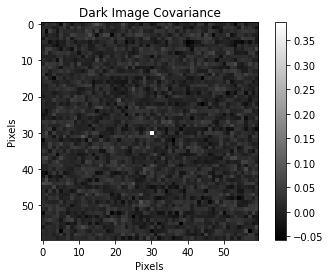

In [ ]:
f = plt.figure()
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(covariance, cmap = 'gray')
plt.title('Dark Image Covariance')
plt.colorbar()

In [ ]:
## Part 1
# Taking 300 frames light images at 100x100 AOI to calculate covariance and noise spectrum
x0, y0 = 0, 0
# this sets the width and height of the rectangle. 
# Focus: 0.4
# Aperature: 6

width, height = 1280, 1024
cam._set_AOI(x0, y0, width, height)
cam._get_AOI()
 
x2 = np.zeros((300,100,100))    
for i in range(300):
    print(i)
    #take an image
    img = cam.grab_image().copy()
    x2[i,:,:] = img[200:300,400:500]

In [ ]:
## Part 1
# Out of focus
# Focus: 
# Aperature: 6
cam._set_AOI(x0, y0, width, height)
x3 = np.zeros((300,100,100))    
for i in range(300):
    print(i)
    #take an image
    img = cam.grab_image().copy()
    x3[i,:,:] = img[200:300,400:500]


In [ ]:
sio.savemat("300framesAOIlight_focused_part1_Feb13.mat", {"Images":x2})
sio.savemat("300framesAOIlight_unfocused_part1_Feb13.mat", {"Images":x3})

In [ ]:
x2 = sio.loadmat("/content/drive/MyDrive/Imaging_Instrumentation_Labs/Lab 2/300framesAOIlight_focused_part1.mat")["Images"]
x3 = sio.loadmat("/content/drive/MyDrive/Imaging_Instrumentation_Labs/Lab 2/300framesAOIlight_unfocused_part1.mat")["Images"]

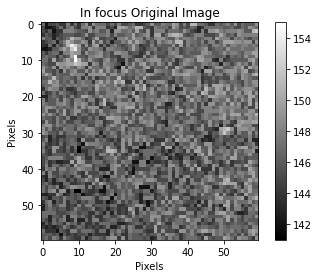

In [ ]:
# x2 = sio.loadmat("/content/drive/MyDrive/Imaging_Instrumentation_Labs/Lab 2/300framesAOIlight_focused_part1.mat")["Images"]
x2 = x2[:,0:60,0:60]
f = plt.figure()
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(x2[1,:,:], cmap = 'gray')
plt.title('In focus Original Image')
plt.colorbar()

In [ ]:
## Part 1: Find covariance and NPS of focused and unfocused image
## Convariance and NPS of Focused image
y_focused = x2.astype('float')
y_focused_avg = np.mean(y_focused, axis = 0)
y_minus_yavg_focused = np.zeros((x2.shape[0], x2.shape[1], x2.shape[2]))
x_minus_xavg_focused = np.zeros((x2.shape[0],1,1))
for i in range(x2.shape[0]):
    y_minus_yavg_focused[i,:,:] = y_focused[i,:,:] - y_focused_avg[:,:]
    x_minus_xavg_focused[i] = y_focused[i,30,30] - y_focused_avg[30,30]
product_focused = np.sum(np.multiply(x_minus_xavg_focused ,y_minus_yavg_focused),axis = 0)
covariance_focused = product_focused/299

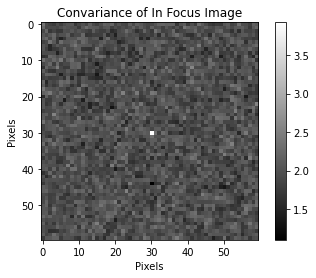

In [ ]:
f = plt.figure()
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(covariance_focused, cmap = 'gray')
plt.title('Convariance of In Focus Image')
plt.colorbar()

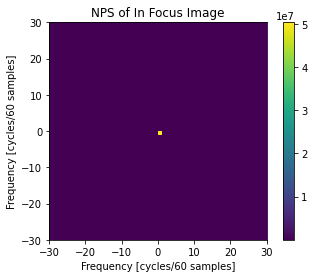

In [ ]:
##To meansure NPS
##image->2D FFT -> low frequency detrending -> Data reduction -> 1D NPS -> characteristic curve -> 1D NPS interms of fluctuation in x-ray exposure
nps_focused = np.abs(np.fft.fftshift(np.fft.fft2(covariance_focused)))**2
f = plt.figure()
plt.imshow(nps_focused,extent = (-30,30,-30,30))
plt.xlabel("Frequency [cycles/60 samples]")
plt.ylabel("Frequency [cycles/60 samples]")
plt.title("NPS of In Focus Image")
plt.colorbar()

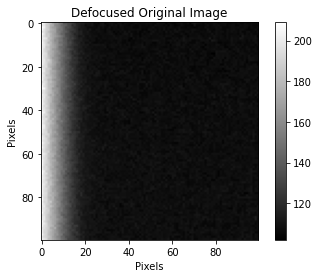

In [5]:
x3 = sio.loadmat("/content/drive/MyDrive/Imaging_Instrumentation_Labs/Lab 2/Data/300framesAOIlight_unfocused_part1_Feb13.mat")["Images"]
# x3 = x3[:,0:60,0:60]
f = plt.figure()
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(x3[200,:,:], cmap = 'gray')
plt.title('Defocused Original Image')
plt.colorbar()

In [6]:
## Convariance and NPS of DeFocused image
y_Defocused = x3.astype('float')
y_Defocused_avg = np.mean(y_Defocused, axis = 0)
y_minus_yavg_Defocused = np.zeros((x3.shape[0], x3.shape[1], x3.shape[2]))
x_minus_xavg_Defocused = np.zeros((x3.shape[0],1,1))
for i in range(x3.shape[0]):
    y_minus_yavg_Defocused[i,:,:] = y_Defocused[i,:,:] - y_Defocused_avg[:,:]
    x_minus_xavg_Defocused[i] = y_Defocused[i,50,50] - y_Defocused_avg[50,50]
product_Defocused = np.sum(np.multiply(x_minus_xavg_Defocused ,y_minus_yavg_Defocused),axis = 0)
covariance_Defocused = product_Defocused/299

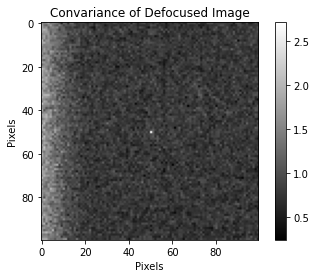

In [7]:
f = plt.figure()
plt.xlabel("Pixels")
plt.ylabel("Pixels")
plt.imshow(covariance_Defocused, cmap = 'gray')
plt.title('Convariance of Defocused Image')
plt.colorbar()

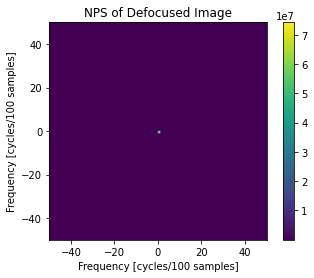

In [8]:
##To meansure NPS
##image->2D FFT -> low frequency detrending -> Data reduction -> 1D NPS -> characteristic curve -> 1D NPS interms of fluctuation in x-ray exposure
nps_defocused = np.abs(np.fft.fftshift(np.fft.fft2(covariance_Defocused)))**2
f = plt.figure()
plt.imshow(nps_defocused,extent = (-50,50,-50,50))
plt.xlabel("Frequency [cycles/100 samples]")
plt.ylabel("Frequency [cycles/100 samples]")
plt.title("NPS of Defocused Image")
plt.colorbar()

In [ ]:
## Part 2: 50 frames line target 
x0, y0 = 0, 0
# this sets the width and height of the rectangle. 


width, height = 1280, 1024
cam._set_AOI(x0, y0, width, height)
cam._get_AOI()
 
x11 = np.zeros((50,1024,1280))    
for i in range(50):
    print(i)
   
    #take an image
    img = cam.grab_image().copy()

    x11[i,:,:] = img
    
average_line_defocus8 = np.mean(x11, axis = 0)
    

In [ ]:
sio.savemat("50frames_lineTargetDefocus8_part2.mat", {"Images":x11, "Average":average_line_defocus8})

In [ ]:
## Part 2: 50 frames star target 
x0, y0 = 0, 0
# this sets the width and height of the rectangle. 


width, height = 1280, 1024
cam._set_AOI(x0, y0, width, height)
cam._get_AOI()
 
x12 = np.zeros((50,1024,1280))    
for i in range(50):
    print(i)
   
    #take an image
    img = cam.grab_image().copy()

    x12[i,:,:] = img
    
average_star_defocus8 = np.mean(x12, axis = 0)

In [ ]:
sio.savemat("50frames_starTarget_defocus8_part2.mat", {"Images":x12, "Average":average_star_defocus8})

In [ ]:
## Part 2: 50 frames knife target (repeated at different angles)
x0, y0 = 0, 0
# this sets the width and height of the rectangle. 


width, height = 1280, 1024
cam._set_AOI(x0, y0, width, height)
cam._get_AOI()
 
x13 = np.zeros((50,1024,1280))    
for i in range(50):
    print(i)
   
    #take an image
    img = cam.grab_image().copy()

    x13[i,:,:] = img
    
average_knife_defocus8 = np.mean(x13, axis = 0)

In [ ]:
sio.savemat("50frames_knifeTarget_defocus8_part2.mat", {"Images":x13, "Average":average_knife_defocus8})

In [ ]:
sio.savemat("50frames_knifeTarget_defocus8_angle2_part2.mat", {"Images":x14, "Average":average_knife2_defocus8})

In [ ]:
line_focus = sio.loadmat("50frames_lineTarget_part2.mat")["Images"]
line_focus_averaged = sio.loadmat("50frames_lineTarget_part2.mat")["Average"]

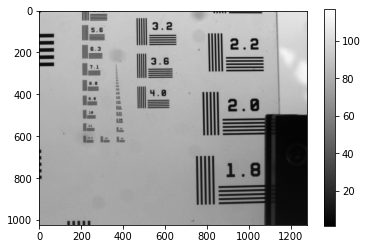

In [ ]:
plt.figure()
plt.imshow(line_focus[5,:,:],cmap = "gray")
plt.colorbar()

In [ ]:
knife_focus = sio.loadmat("50frames_knifeTarget_angle2_part2.mat")["Images"]
knife_focus_averaged = sio.loadmat("50frames_knifeTarget_angle2_part2.mat")["Average"]

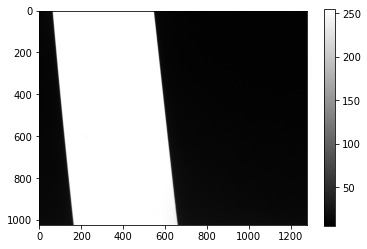

In [ ]:
plt.figure()
plt.imshow(knife_focus[5,:,:],cmap = "gray")
plt.colorbar()

In [ ]:
import cv2
import scipy.stats as stats
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression

In [ ]:
knife_focus = sio.loadmat('/content/drive/My Drive/50frames_knifeTarget_angle2_part2.mat')["Average"] # Maybe crop differently
#linePair = sio.loadmat('/content/drive/My Drive/50frames_knifeTarget_angle2_part2.mat')["Average"])
# Line pair equivalent to cycles, spatial frequency

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Text(0.5, 1.0, 'Knife Edge Image, Focused')

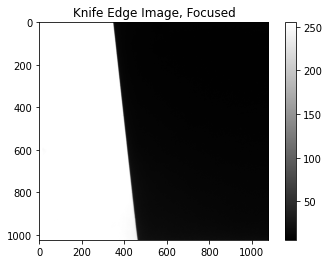

In [ ]:
plt.figure()
plt.imshow(knife_focus[:,200:-1], cmap = "gray")
plt.colorbar()
plt.title("Knife Edge Image, Focused")

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
intercept: -3117.895496984186
slope: [8.93007557]
Great Bins


Text(0, 0.5, 'MTF')

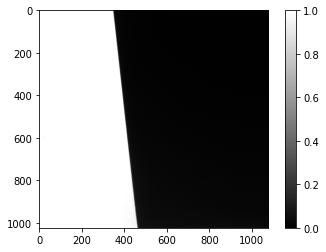

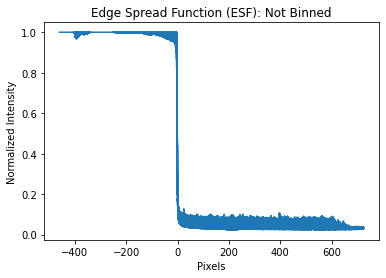

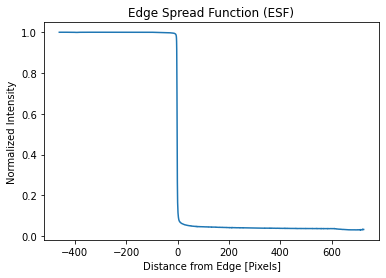

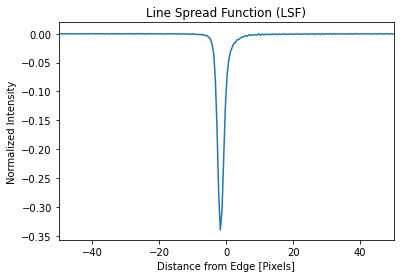

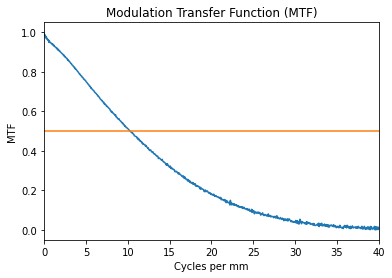

In [ ]:
## Part 2: Calculating MTF: Focused Knife edge image

# 1) Edge detection to find pixels along line (pixel closest to 50%, normalize)
# Average images

# Normalization
t = 50
# Crop first 200 columns
binary_mask = np.array(1*(knife_focus[:,200:-1] > t))
knife_focus2 = knife_focus[:,200:-1]
plt.imshow(binary_mask,cmap="gray")
plt.colorbar()
print(binary_mask[:,340:500])
# Avg
linePixels_x_axis = np.zeros((1024))
linePixels = np.zeros((2,1024))

for i in range(1024):
    #Going through each row, save the y index for the first time the value is 1
    #print(np.where(binary_mask[i,:] == 1)[0][0])
    #linePixels_x_axis[i] = np.where(binary_mask[i,:] == 1)[0][0]
    
    linePixels[0,i] = (i)
    linePixels[1,i] = np.where(binary_mask[i,:] == 0)[0][0]


#plt.imshow(binary_mask); plt.plot(linePixels[1], linePixels[0])

# 2) Use pixels along line to get y = mx+b equation of line (point slope form); linear fit function (whole row at once, min distance)
#    Linear interpolation to get line? https://realpython.com/linear-regression-in-python/
xVals = linePixels[1,:].reshape((-1, 1))
yVals = linePixels[0,:]
#print(xVals[:150])
#print(yVals[:150])
model = LinearRegression().fit(xVals, yVals)
print(f"intercept: {model.intercept_}")

print(f"slope: {model.coef_}")
# 3) Find distance, D, from line to each pixel to the left (perpendicular distance formula) (all computed simultaneously), create matrices of x and y value to compute distances all at once
#    Use cropped image? nothing left of pixel 200 https://stackoverflow.com/questions/57063442/measuring-distance-from-points-to-a-line
a = model.coef_
b = -1
c = model.intercept_

x = np.arange(0, knife_focus2.shape[1])
y = np.arange(0, knife_focus2.shape[0])

X, Y = np.meshgrid(x,y)

D = (a*X + b*Y + c)/(np.sqrt(a**2 + b**2))

plt.imshow(knife_focus2, cmap = "gray")

# 4) Plot sorted D vs I (intensity of those pixels) --> Edge Spread Function
D_sort1 = np.argsort(D.ravel())
D_sort2 = np.take_along_axis(D.ravel(), D_sort1, axis = 0)
intensity = np.take_along_axis(knife_focus2.ravel(), D_sort1, axis = 0)/np.max(knife_focus2)

plt.figure()
plt.plot(D_sort2, intensity)
plt.title("Edge Spread Function (ESF): Not Binned")
plt.xlabel("Pixels")
plt.ylabel("Normalized Intensity")
# 5) Bin D vs I plot so it's uniformly sampled (loop), delta d smaller than pixel size
numDistances = np.round(D_sort2[-1] + np.abs(D_sort2[0]))
numBins = 2*numDistances
# 2 bins per pixel
binnedIntensity, binEdges, binNumber = stats.binned_statistic(D_sort2, intensity, 'mean', numBins)
# Check to make sure there's at least one point in every bin
if(1 in np.isnan(binnedIntensity)):
  print('Bins Too Small')
else:
  print('Great Bins')

binEdges = binEdges[1:]
plt.figure()
plt.plot(binEdges, binnedIntensity)
plt.title("Edge Spread Function (ESF)")
plt.xlabel("Distance from Edge [Pixels]")
plt.ylabel("Normalized Intensity")

# 6) Differentiate ESF to get LSF (w filter) (can't have bins w no samples in them)
binSize = binEdges[1] - binEdges[0]
LSF = np.diff(binnedIntensity)/binSize
LSF_x = binEdges[1:]
plt.figure()
plt.plot(LSF_x, LSF)
plt.xlim([-50,50])
plt.title("Line Spread Function (LSF)")
plt.xlabel("Distance from Edge [Pixels]")
plt.ylabel("Normalized Intensity")

# 7) FFT of LSF --> MTF cycles/mm

MTF = np.abs(np.fft.fft(LSF))/np.max(np.abs(np.fft.fft(LSF)[:1000]))
pix = numBins*binSize #bins * pixels/bin
mm = pix * 0.5/34 # pixels * mm/pixel
MTF_x = np.arange(0, len(MTF))/mm # Cycles per mm
half = np.zeros(len(MTF_x))
half[:] = 0.5
plt.figure()
plt.plot(MTF_x, MTF); plt.plot(MTF_x, half)
plt.xlim([0,40])
plt.title("Modulation Transfer Function (MTF)")
plt.xlabel("Cycles per mm")
plt.ylabel("MTF")

In [ ]:
line_focus = sio.loadmat('/content/drive/My Drive/50frames_lineTarget_part2.mat')["Average"] # Maybe crop differently

In [ ]:
## Part 2: Finding number of pixels per mm in our images using the line pair targets

line_focus = line_focus.astype('float64')

px.imshow(line_focus[500:700, 850:1050], color_continuous_scale = "gray", width = 1000, height = 1000) # Rows 500 to 700, columns 850 to 1050
# 34 pixels per mm

In [ ]:
knife_defocus4 = sio.loadmat('/content/drive/My Drive/50frames_knifeTarget_defocus4_angle2_part2.mat')["Average"] 

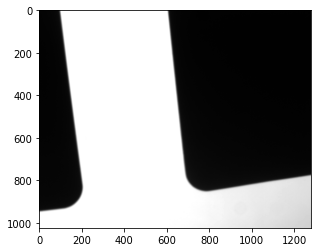

In [ ]:
plt.figure()
plt.imshow(knife_defocus4, cmap = "gray")

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
intercept: -2868.360378724122
slope: [9.25487939]
Great Bins


Text(0, 0.5, 'MTF')

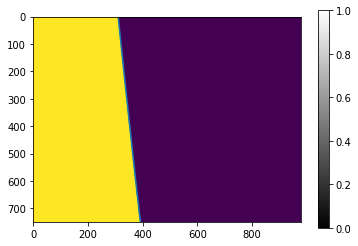

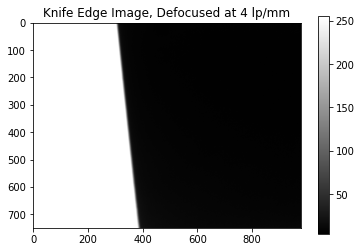

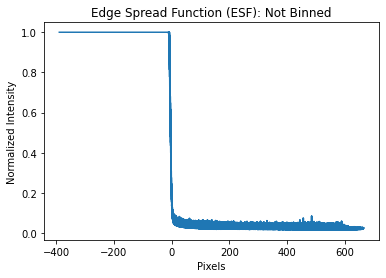

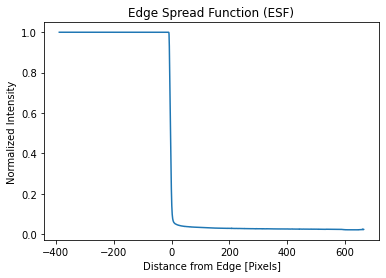

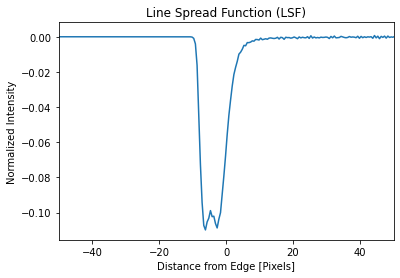

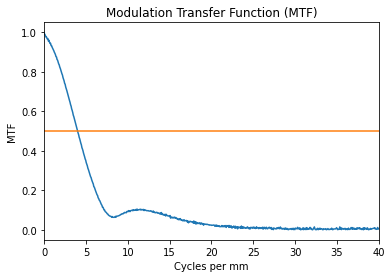

In [ ]:
## Part 2: Calculating MTF: Defocused to the 4 line pairs/ mm Knife edge image

# 1) Edge detection to find pixels along line (pixel closest to 50%, normalize)
# Average images

# Normalization
t = 50
# Crop first 200 columns
binary_mask = np.array(1*(knife_defocus4[:750,300:-1] > t))
knife_defocus4_2 = knife_defocus4[:750,300:-1]
plt.imshow(binary_mask,cmap="gray")
plt.colorbar()
print(binary_mask[:,340:500])
# Avg
linePixels_x_axis = np.zeros((750))
linePixels = np.zeros((2,750))

for i in range(750):
    #Going through each row, save the y index for the first time the value is 1
    #print(np.where(binary_mask[i,:] == 1)[0][0])
    #linePixels_x_axis[i] = np.where(binary_mask[i,:] == 1)[0][0]
    
    linePixels[0,i] = (i)
    linePixels[1,i] = np.where(binary_mask[i,:] == 0)[0][0]


plt.imshow(binary_mask); plt.plot(linePixels[1], linePixels[0])

# 2) Use pixels along line to get y = mx+b equation of line (point slope form); linear fit function (whole row at once, min distance)
#    Linear interpolation to get line? https://realpython.com/linear-regression-in-python/
xVals = linePixels[1,:].reshape((-1, 1))
yVals = linePixels[0,:]
#print(xVals[:150])
#print(yVals[:150])
model = LinearRegression().fit(xVals, yVals)
print(f"intercept: {model.intercept_}")

print(f"slope: {model.coef_}")
# 3) Find distance, D, from line to each pixel to the left (perpendicular distance formula) (all computed simultaneously), create matrices of x and y value to compute distances all at once
#    Use cropped image? nothing left of pixel 200 https://stackoverflow.com/questions/57063442/measuring-distance-from-points-to-a-line
a = model.coef_
b = -1
c = model.intercept_

x = np.arange(0, knife_defocus4_2.shape[1])
y = np.arange(0, knife_defocus4_2.shape[0])

X, Y = np.meshgrid(x,y)

D = (a*X + b*Y + c)/(np.sqrt(a**2 + b**2))

plt.figure()
plt.imshow(knife_defocus4_2, cmap = "gray")
plt.title("Knife Edge Image, Defocused at 4 lp/mm")
plt.colorbar()

# 4) Plot sorted D vs I (intensity of those pixels) --> Edge Spread Function
D_sort1 = np.argsort(D.ravel())
D_sort2 = np.take_along_axis(D.ravel(), D_sort1, axis = 0)
intensity = np.take_along_axis(knife_defocus4_2.ravel(), D_sort1, axis = 0)/np.max(knife_defocus4_2)

plt.figure()
plt.plot(D_sort2, intensity)
plt.title("Edge Spread Function (ESF): Not Binned")
plt.xlabel("Pixels")
plt.ylabel("Normalized Intensity")
# 5) Bin D vs I plot so it's uniformly sampled (loop), delta d smaller than pixel size
numDistances = np.round(D_sort2[-1] + np.abs(D_sort2[0]))
numBins = 2*numDistances
# 2 bins per pixel
binnedIntensity, binEdges, binNumber = stats.binned_statistic(D_sort2, intensity, 'mean', numBins)
# Check to make sure there's at least one point in every bin
if(1 in np.isnan(binnedIntensity)):
  print('Bins Too Small')
else:
  print('Great Bins')

binEdges = binEdges[1:]
plt.figure()
plt.plot(binEdges, binnedIntensity)
plt.title("Edge Spread Function (ESF)")
plt.xlabel("Distance from Edge [Pixels]")
plt.ylabel("Normalized Intensity")

# 6) Differentiate ESF to get LSF (w filter) (can't have bins w no samples in them)
binSize = binEdges[1] - binEdges[0]
LSF = np.diff(binnedIntensity)/binSize
LSF_x = binEdges[1:]
plt.figure()
plt.plot(LSF_x, LSF)
plt.xlim([-50,50])
plt.title("Line Spread Function (LSF)")
plt.xlabel("Distance from Edge [Pixels]")
plt.ylabel("Normalized Intensity")

# 7) FFT of LSF --> MTF cycles/mm

MTF = np.abs(np.fft.fft(LSF))/np.max(np.abs(np.fft.fft(LSF)[:1000]))
pix = numBins*binSize #bins * pixels/bin
mm = pix * 0.5/34 # pixels * mm/pixel
MTF_x = np.arange(0, len(MTF))/mm # Cycles per mm

half = np.zeros(len(MTF_x))
half[:] = 0.5
plt.figure()
plt.plot(MTF_x, MTF); plt.plot(MTF_x, half)
plt.xlim([0,40])
plt.title("Modulation Transfer Function (MTF)")
plt.xlabel("Cycles per mm")
plt.ylabel("MTF")

In [ ]:
knife_defocus8 = sio.loadmat('/content/drive/My Drive/50frames_knifeTarget_defocus8_angle2_part2.mat')["Average"] 


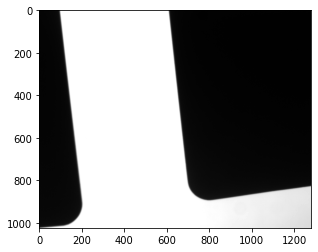

In [ ]:
plt.figure()
plt.imshow(knife_defocus8, cmap = "gray")

[[1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 ...
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]
 [1 1 1 ... 0 0 0]]
intercept: -3279.4713491916077
slope: [9.02959085]
Great Bins


Text(0, 0.5, 'MTF')

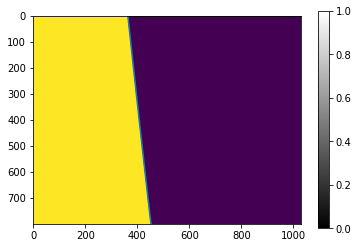

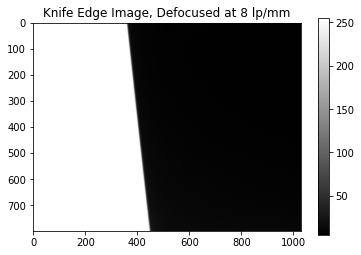

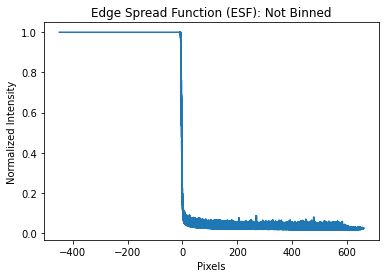

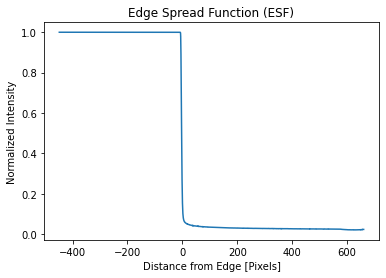

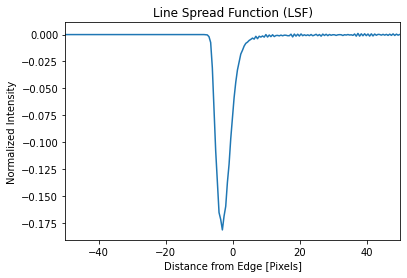

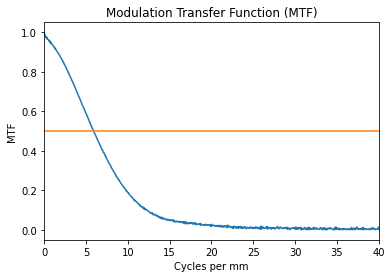

In [ ]:
## Part 2: Calculating MTF: Defocused to the 8 line pairs/ mm Knife edge image

# 1) Edge detection to find pixels along line (pixel closest to 50%, normalize)
# Average images

# Normalization
t = 50
# Crop first 200 columns
binary_mask = np.array(1*(knife_defocus8[:800,250:-1] > t))
knife_defocus8_2 = knife_defocus8[:800,250:-1]
plt.imshow(binary_mask,cmap="gray")
plt.colorbar()
print(binary_mask[:,340:500])
# Avg
linePixels_x_axis = np.zeros((800))
linePixels = np.zeros((2,800))

for i in range(800):
    #Going through each row, save the y index for the first time the value is 1
    #print(np.where(binary_mask[i,:] == 1)[0][0])
    #linePixels_x_axis[i] = np.where(binary_mask[i,:] == 1)[0][0]
    
    linePixels[0,i] = (i)
    linePixels[1,i] = np.where(binary_mask[i,:] == 0)[0][0]


plt.imshow(binary_mask); plt.plot(linePixels[1], linePixels[0])


# 2) Use pixels along line to get y = mx+b equation of line (point slope form); linear fit function (whole row at once, min distance)
#    Linear interpolation to get line? https://realpython.com/linear-regression-in-python/
xVals = linePixels[1,:].reshape((-1, 1))
yVals = linePixels[0,:]
#print(xVals[:150])
#print(yVals[:150])
model = LinearRegression().fit(xVals, yVals)
print(f"intercept: {model.intercept_}")

print(f"slope: {model.coef_}")
# 3) Find distance, D, from line to each pixel to the left (perpendicular distance formula) (all computed simultaneously), create matrices of x and y value to compute distances all at once
#    Use cropped image? nothing left of pixel 200 https://stackoverflow.com/questions/57063442/measuring-distance-from-points-to-a-line
a = model.coef_
b = -1
c = model.intercept_

x = np.arange(0, knife_defocus8_2.shape[1])
y = np.arange(0, knife_defocus8_2.shape[0])

X, Y = np.meshgrid(x,y)

D = (a*X + b*Y + c)/(np.sqrt(a**2 + b**2))

plt.figure()
plt.imshow(knife_defocus8_2, cmap = "gray")
plt.title("Knife Edge Image, Defocused at 8 lp/mm")
plt.colorbar()

# 4) Plot sorted D vs I (intensity of those pixels) --> Edge Spread Function
D_sort1 = np.argsort(D.ravel())
D_sort2 = np.take_along_axis(D.ravel(), D_sort1, axis = 0)
intensity = np.take_along_axis(knife_defocus8_2.ravel(), D_sort1, axis = 0)/np.max(knife_defocus8_2)

plt.figure()
plt.plot(D_sort2, intensity)
plt.title("Edge Spread Function (ESF): Not Binned")
plt.xlabel("Pixels")
plt.ylabel("Normalized Intensity")
# 5) Bin D vs I plot so it's uniformly sampled (loop), delta d smaller than pixel size
numDistances = np.round(D_sort2[-1] + np.abs(D_sort2[0]))
numBins = 2*numDistances
# 2 bins per pixel
binnedIntensity, binEdges, binNumber = stats.binned_statistic(D_sort2, intensity, 'mean', numBins)
# Check to make sure there's at least one point in every bin
if(1 in np.isnan(binnedIntensity)):
  print('Bins Too Small')
else:
  print('Great Bins')

binEdges = binEdges[1:]
plt.figure()
plt.plot(binEdges, binnedIntensity)
plt.title("Edge Spread Function (ESF)")
plt.xlabel("Distance from Edge [Pixels]")
plt.ylabel("Normalized Intensity")

# 6) Differentiate ESF to get LSF (w filter) (can't have bins w no samples in them)
binSize = binEdges[1] - binEdges[0]
LSF = np.diff(binnedIntensity)/binSize
LSF_x = binEdges[1:]
plt.figure()
plt.plot(LSF_x, LSF)
plt.xlim([-50,50])
plt.title("Line Spread Function (LSF)")
plt.xlabel("Distance from Edge [Pixels]")
plt.ylabel("Normalized Intensity")

# 7) FFT of LSF --> MTF cycles/mm

MTF = np.abs(np.fft.fft(LSF))/np.max(np.abs(np.fft.fft(LSF)[:1000]))
pix = numBins*binSize #bins * pixels/bin
mm = pix * 0.5/34 # pixels * mm/pixel
MTF_x = np.arange(0, len(MTF))/mm # Cycles per mm

half = np.zeros(len(MTF_x))
half[:] = 0.5
plt.figure()
plt.plot(MTF_x, MTF); plt.plot(MTF_x, half)
plt.xlim([0,40])
plt.title("Modulation Transfer Function (MTF)")
plt.xlabel("Cycles per mm")
plt.ylabel("MTF")

In [ ]:
# Loading required images for analysis
line_focus = sio.loadmat('/content/drive/My Drive/50frames_lineTarget_part2.mat')["Average"] 
line_defocus8 = sio.loadmat('/content/drive/My Drive/50frames_lineTargetDefocus8_part2.mat')["Average"] 
line_defocus4 = sio.loadmat('/content/drive/My Drive/50frames_lineTargetDefocus4_part2.mat')["Average"] 
star_focus = sio.loadmat('/content/drive/My Drive/50frames_starTarget_part2.mat')["Average"] 
star_defocus8 = sio.loadmat('/content/drive/My Drive/50frames_starTarget_defocus8_part2.mat')["Average"] 
star_defocus4 = sio.loadmat('/content/drive/My Drive/50frames_starTarget_defocus4_part2.mat')["Average"] 

#knife_defocus8 = sio.loadmat('/content/drive/My Drive/50frames_knifeTarget_defocus8_angle2_part2.mat')["Average"] 

In [ ]:
##Part 3

line_part3 = sio.loadmat('/content/drive/My Drive/LineF_part3.mat')["Average"]
star_part3 = sio.loadmat('/content/drive/My Drive/StarF_part3.mat')["Average"]

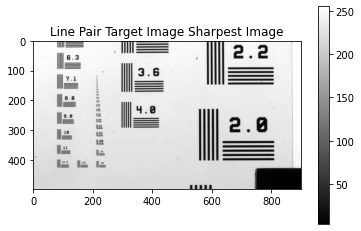

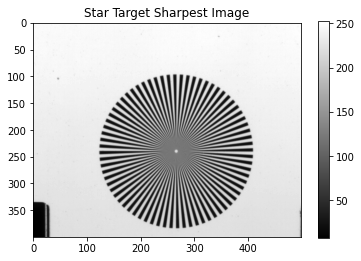

In [ ]:
plt.figure()
plt.imshow(line_part3[:500, 200:1100], cmap = "gray")
plt.title("Line Pair Target Image Sharpest Image")
plt.colorbar()

plt.figure()
plt.imshow(star_part3[0:400, 400:900], cmap = "gray")
plt.title("Star Target Sharpest Image")
plt.colorbar()


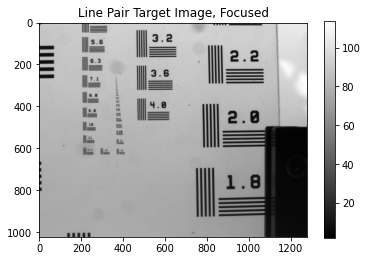

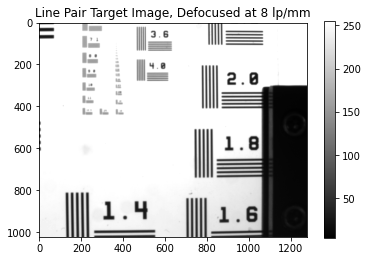

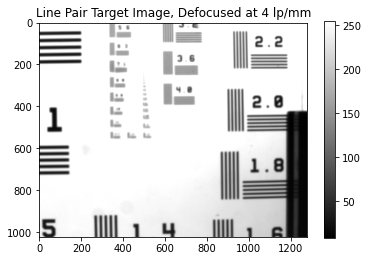

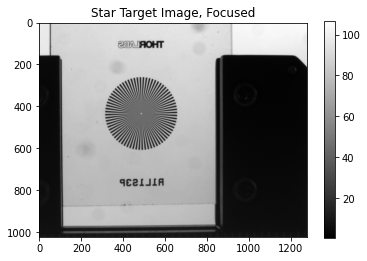

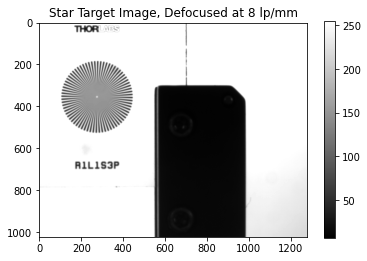

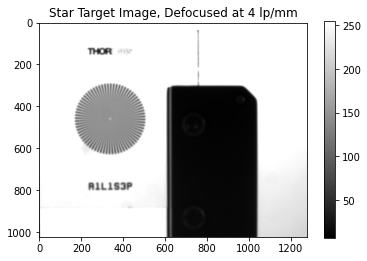

In [ ]:
# Displaying required images

plt.figure()
plt.imshow(line_focus, cmap = "gray")
plt.title("Line Pair Target Image, Focused")
plt.colorbar()

plt.figure()
plt.imshow(line_defocus8, cmap = "gray")
plt.title("Line Pair Target Image, Defocused at 8 lp/mm")
plt.colorbar()

plt.figure()
plt.imshow(line_defocus4, cmap = "gray")
plt.title("Line Pair Target Image, Defocused at 4 lp/mm")
plt.colorbar()

plt.figure()
plt.imshow(star_focus, cmap = "gray")
plt.title("Star Target Image, Focused")
plt.colorbar()

plt.figure()
plt.imshow(star_defocus8, cmap = "gray")
plt.title("Star Target Image, Defocused at 8 lp/mm")
plt.colorbar()

plt.figure()
plt.imshow(star_defocus4, cmap = "gray")
plt.title("Star Target Image, Defocused at 4 lp/mm")
plt.colorbar()

#plt.title("Knife Edge Image, Defocused at 8 lp/mm")

In [ ]:
binEdges[56] - binEdges[55]

0.5000629114463777

In [ ]:
## Part 2: MTF of defocused 4 knife image (most defocused)
from google.colab import drive
drive.mount('/content/drive')
knife_focus = sio.loadmat('/content/drive/My Drive//50frames_knifeTarget_defocus4_angle2_part2.mat')["Average"] # Maybe crop diff

In [ ]:
## Part 2: MTF of defocused 8 knife image (middle defocused)

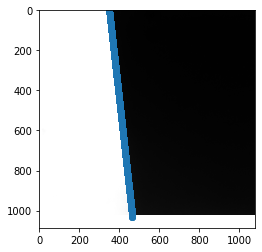

In [ ]:
plt.imshow(knife_focus2, cmap = "gray") ; plt.plot(linePixels[1,:], a*(linePixels[1,:]) + c, "o")

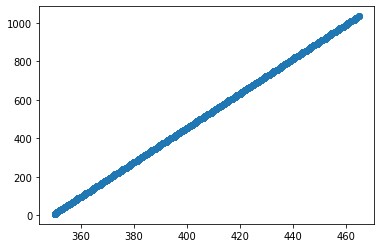

In [ ]:
plt.plot(linePixels[1,:], a*(linePixels[1,:]) + c, "o")

In [ ]:
print(x)
print(x.shape)
print(y)
print(y.shape)
print(X)
print(X.shape)
print(Y)
print(Y.shape)


[   0    1    2 ... 1021 1022 1023]
(1024,)
[   0    1    2 ... 1076 1077 1078]
(1079,)
[[   0    1    2 ... 1021 1022 1023]
 [   0    1    2 ... 1021 1022 1023]
 [   0    1    2 ... 1021 1022 1023]
 ...
 [   0    1    2 ... 1021 1022 1023]
 [   0    1    2 ... 1021 1022 1023]
 [   0    1    2 ... 1021 1022 1023]]
(1079, 1024)
[[   0    0    0 ...    0    0    0]
 [   1    1    1 ...    1    1    1]
 [   2    2    2 ...    2    2    2]
 ...
 [1076 1076 1076 ... 1076 1076 1076]
 [1077 1077 1077 ... 1077 1077 1077]
 [1078 1078 1078 ... 1078 1078 1078]]
(1079, 1024)


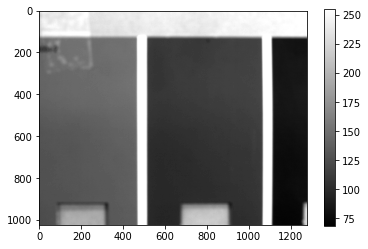

In [ ]:
img3 = cam.grab_image().copy()
im3 = plt.imshow(img3,cmap='gray')
plt.colorbar(im3)

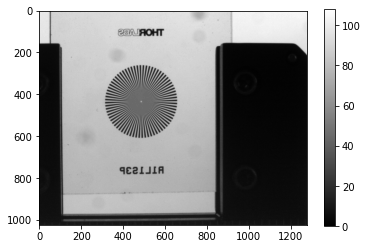

In [ ]:
img4 = cam.grab_image().copy()
im4 = plt.imshow(img4,cmap='gray')
plt.colorbar(im4)

#### Live Video Feed for tuning focal length and aperture. 

In [ ]:
cam._get_AOI() # look at the Area of Interest. 

(0, 0, 1280, 1024)

In [ ]:
# set frame rate
cam.set_framerate(framerate = "10Hz")
# get exposure range, you can see that the frame rate will change the maximum exposure time. 
print(cam._get_exposure_range())
# print current frame rate
print(cam.framerate) 

(<Quantity(0.00898245614, 'millisecond')>, <Quantity(197.594526, 'millisecond')>)
5.05606735178449 hertz


In [ ]:
# to quit press live feed press "q"
cam.start_live_video()
while cam.is_open:
     
     frame = cam.grab_image(timeout='100s', copy=True)
     frame1 = np.stack((frame,) * 3,-1) #make frame as 1 channel image
     frame1 = frame1.astype(np.uint8)
     gray = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)
     #now u can apply opencv features
     cv2.imshow('Camera', gray)
     if cv2.waitKey(30) & 0xFF == ord('q'):
        break
cam.stop_live_video()
cv2.destroyAllWindows()

2.0472896614601814 hertz


In [ ]:
cam.close()

In [ ]:
del cam